# Distribution of Colours
This notebook plots the distribution of most excitatory and most inhibitory colours for spectrally opponent cells at different depths in our model. It corresponds to Figure 4 from the paper.

**Note**: The easiest way to use this is as a colab notebook, which allows you to dive in with no setup.

## Load Dependencies - Colab Only

In [ ]:
from os.path import exists
if not exists('opponency.zip'):
    !wget -O opponency.zip https://github.com/ecs-vlc/opponency/archive/master.zip
    !unzip -qq opponency.zip
    !mv opponency-master/* ./
    !rm -r opponency-master

## Generate Plots

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.font_manager
rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size':13})
rc('text', usetex=True)
# plt.rcParams.update({'font.size': 18})
import pandas as pd
import numpy as np
from scipy import stats

from matplotlib import cm
import matplotlib as mpl
from scipy.stats import gaussian_kde

# 'yellow': ((30, 90), 'y', '-'),

COLORS = {'Red': ((315, 45), 'r', '-.'), 'Green': ((75, 165), 'g', '--'),
          'Magenta': ((285, 315), 'm', '-.'), 'Cyan': ((165, 195), 'c', '--'),
          'Yellow': ((45, 75), 'y', '-.'), 'Blue': ((195, 285), 'b', '--')}

titles = {'retina_relu2': 'Retina 2', 'ventral_relu0': 'Ventral 1',
          'ventral_relu1': 'Ventral 2'}

def plot(ax, orig_frame, layer, n_bn, d_vvs, colors, label, legend, title, ylabel):
#     norm = mpl.colors.Normalize(0, 2*np.pi)

#     # Plot a color mesh on the polar plot
#     # with the color set by the angle

#     n = 2000  #the number of secants for the mesh
#     t = np.linspace(0,2*np.pi,n)   #theta values
#     r = np.linspace(0.85,1,2)        #radius values change 0.6 to 0 for full circle
#     rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
#     c = tg                         #define color values as theta value
#     im = ax.pcolormesh(t, r, c.T, norm=norm, cmap='hsv')  #plot the colormesh on axis with colormap
    
#     ax.axis('off')
#     ax.spines['polar'].set_visible(False)    #turn off the axis spine.
    
    for color in colors:
        section = COLORS[color][0]

        frame = orig_frame[orig_frame['layer'] == layer.lower().replace(' ', '_')].copy()
#         frame = frame[frame['class'] == 'spectrally opponent']

        if section[1] < section[0]:
            frame = pd.concat((
                frame[frame['min_params'] >= section[0]],
                frame[frame['min_params'] < section[1]]
            ))
        else:
            frame = frame[frame['min_params'] >= section[0]]
            frame = frame[frame['min_params'] < section[1]]

        frame['max_params'] = (frame['max_params'] * 2 * np.pi) / 360
        frame['min_params'] = (frame['min_params'] * 2 * np.pi) / 360

        exs = []

        main_frame = frame

        for rep in range(9):
#             for d in d_vvs:
#                 for n in n_bn:
            frame = main_frame[main_frame['rep'] == rep]
            frames = [frame[frame['d_vvs'] == d] for d in d_vvs if len(frame[frame['d_vvs'] == d]) > 0]
            if len(frames) > 0:
                frame = pd.concat(frames)
                frames = [frame[frame['n_bn'] == n] for n in n_bn if len(frame[frame['n_bn'] == n]) > 0]
                if len(frames) > 0:
                    frame = pd.concat(frames)
                else:
                    frame = None
            else:
                frame = None
            
#             frames = [frame[frame['n_bn'] == n] for n in n_bn if len(frame[frame['n_bn'] == n]) > 0]
#             if len(frames) > 0:
#                 frame = pd.concat(frames)
#             else:
#                 continue
#             frame = frame[frame['n_bn'] == n]

#             print(frame['max_params'])
            if frame is not None:
                ex = np.histogram(frame['max_params'], bins=45, range=(0,2 * np.pi), density=True)
            else:
                ex = ([0]*45, np.linspace(0, 2 * np.pi, 46))
            
            def get_data(x):
                xs = list(x[1])
#                     xs = my_x

                ys = list(x[0])
                ys.append(ys[0])

                return xs, ys

            x, y = get_data(ex)
            exs.append(y)
    
        exs = np.array(exs)

        ex_mean = np.mean(exs, axis=0)

        x = (np.array(x) * 360) / (2 * np.pi)
        
        ax.plot(x, ex_mean, linestyle=COLORS[color][2], label=f'{color} Inhibition', color=COLORS[color][1])

        ex_std = np.std(exs, axis=0)

        ax.fill_between(
            x,
            ex_mean + ex_std,
            ex_mean - ex_std,
            alpha=0.1,
            facecolor=COLORS[color][1]
        )
        
    ax.set_xlim(0, 360)
    ax.set_ylim(0)  # , 1 / (2 * np.pi / 45))
    ax.set_yticks([], [])
    ax.set_xticks([], [])
    if legend:
        ax.legend(frameon=False, loc='upper left')
    
#     if label:
#         ax.set_ylabel('Excitation')
    
    if title:
        ax.set_title(titles[layer], pad=25)
    
    if ylabel is not None and layer == 'retina_relu2':
        ax.set_ylabel(ylabel, labelpad=25, fontsize='large')

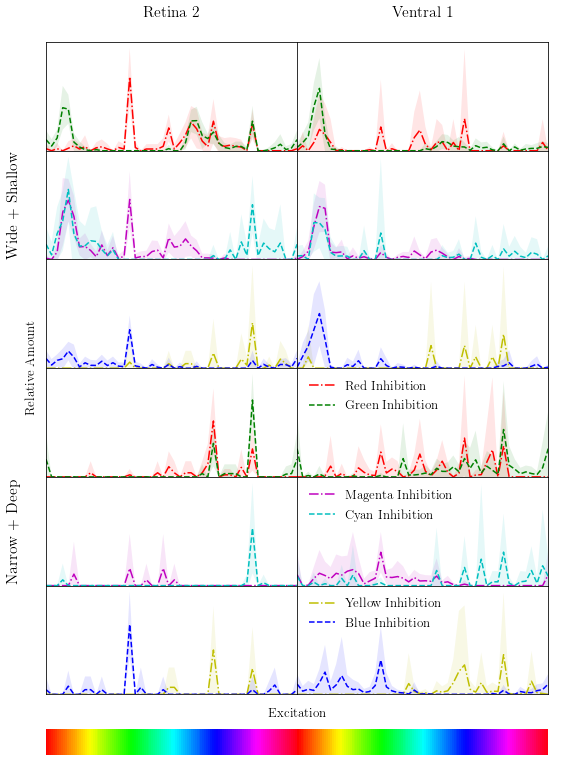

In [24]:
layers = ['retina_relu2', 'ventral_relu0']

params = [
    ([8, 16, 32], [0, 1], pd.read_pickle('statistics/devalois.pd'), ['Red', 'Green'], False, None),
    ([8, 16, 32], [0, 1], pd.read_pickle('statistics/devalois.pd'), ['Magenta', 'Cyan'], False, 'Wide + Shallow'),
    ([8, 16, 32], [0, 1], pd.read_pickle('statistics/devalois.pd'), ['Yellow', 'Blue'], False, None),
    ([1, 2, 4], [3, 4], pd.read_pickle('statistics/devalois.pd'), ['Red', 'Green'], True, None),
    ([1, 2, 4], [3, 4], pd.read_pickle('statistics/devalois.pd'), ['Magenta', 'Cyan'], True, 'Narrow + Deep'),
    ([1, 2, 4], [3, 4], pd.read_pickle('statistics/devalois.pd'), ['Yellow', 'Blue'], True, None)
]

fig, axs = plt.subplots(len(params), len(layers), sharex='col', gridspec_kw={'hspace': 0, 'wspace': 0})
fig.set_size_inches(9, 2 * len(params))

fig.add_subplot(111, frameon=False)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Excitation', labelpad=-5)
plt.ylabel('Relative Amount', labelpad=-15)

for i, layer in enumerate(layers):
    for j, param in enumerate(params):
        n_bn, d_vvs, frame, colors, legend, ylabel = param
        try:
            plot(axs[j, i], frame, layer, n_bn, d_vvs, colors, j == len(params) // 2 and i == 0, i == (len(layers) - 1) and legend, j == 0, ylabel)
        except IndexError:
            plot(axs[j], frame, layer, n_bn, d_vvs, colors, j == len(params) // 2 and i == 0, i == (len(layers) - 1) and legend, j == 0, ylabel)

# fig.subplots_adjust(bottom=0.8)
            
cbar_ax = fig.add_axes([0.125, 0.055, 0.775, 0.03])
# fig.colorbar(im, cax=cbar_ax)

from matplotlib import colors

cmap = colors.LinearSegmentedColormap.from_list('hsv2', np.vstack((cm.hsv(np.linspace(0, 1, 360)), cm.hsv(np.linspace(0, 1, 360)))))

cb = fig.colorbar(cm.ScalarMappable(cmap=cmap), orientation='horizontal', ticks=[], cax=cbar_ax)
cb.outline.set_visible(False)

plt.savefig('figures/opponency_type.pdf', bbox_inches='tight')